<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/NN_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 1.1 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

Loading and preprocessing the data

In [4]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteX2CHCV/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [5]:
# By default, the Dataset object is an iterator over the elements.
# The instructions below extract the underlying tensors.
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [7]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [8]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

Define MultiLayer Neural Network

In [9]:
from torch import nn
from torch.nn import functional as F

In [10]:
class MNN(nn.Module):
  def __init__(self, input_size, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
    super().__init__()

    self.w1 = nn.Parameter(fc1w)
    self.b1 = nn.Parameter(fc1b)
    
    self.w2 = nn.Parameter(fc2w)
    self.b2 = nn.Parameter(fc2b)

    self.w3 = nn.Parameter(fc3w)
    self.b3 = nn.Parameter(fc3b)

  def forward(self, x):
    x = F.relu(x@self.w1 + self.b1)
    x = F.relu(x@self.w2 + self.b2)
    x = x@self.w3 + self.b3
    x = x.reshape(1, -1)
    return torch.softmax(x, 1)

In [11]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Initialize the parameters

In [13]:
# We initialize the parameters randomly with values in [-1, 1] and the model with an input size
fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
fc1b = torch.FloatTensor(64).uniform_(-1, 1)
fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
fc2b = torch.FloatTensor(8).uniform_(-1, 1)
fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
fc3b = torch.FloatTensor(3).uniform_(-1, 1)
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)

In [14]:
# Note: we also need to move data when asking for a prediction
print(mnn(Xtrain[0].to(device)))

tensor([[0.0658, 0.9325, 0.0018]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [16]:
def pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, x):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return ypred

Define accuracy

In [15]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [18]:
# Average accuracy at initialization
ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, Xtrain)
accuracy(ytrain.to(device), ypred.to(device))

tensor(0.2640, device='cuda:0')

Define Cross-Entropy

In [20]:
def cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
def cross_entropyBfc1(fc1b, fc1w, fc2w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [22]:
def cross_entropyWfc2(fc2w, fc1b, fc1w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [23]:
def cross_entropyBfc2(fc2b, fc1b, fc2w, fc1w, fc3w, fc3b, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [24]:
def cross_entropyWfc3(fc3w, fc1b, fc2w, fc2b, fc1w, fc3b, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [25]:
def cross_entropyBfc3(fc3b, fc1b, fc2w, fc2b, fc3w, fc1w, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],3))
  for j in range (ytrue.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [27]:
#We check that the output of all the cross_entropy functions is the same
print(cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, ytrain, Xtrain))
print(cross_entropyBfc1(fc1b, fc1w, fc2w, fc2b, fc3w, fc3b, ytrain, Xtrain))
print(cross_entropyWfc2(fc2w, fc1b, fc1w, fc2b, fc3w, fc3b, ytrain, Xtrain))
print(cross_entropyBfc2(fc2b, fc1b, fc2w, fc1w, fc3w, fc3b, ytrain, Xtrain))
print(cross_entropyWfc3(fc3w, fc1b, fc2w, fc2b, fc1w, fc3b, ytrain, Xtrain))
print(cross_entropyBfc3(fc3b, fc1b, fc2w, fc2b, fc3w, fc1w, ytrain, Xtrain))

tensor(2.7839)
tensor(2.7839)
tensor(2.7839)
tensor(2.7839)
tensor(2.7839)
tensor(2.7839)


Define error

In [41]:
def error(ytrue, ypred):
  error=0
  for i in range (ypred.size(0)):
    ypredi = ypred[i].reshape(1, -1)
    if (ypredi.argmax(1)- ytrue[i])!=0:
      error = error+ 1
  return error

In [29]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [28]:
def rosenbrock_function(x):
  sum=0
  for p in x.size():
    for i in range (x.size(1)-1):
      sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(x[i]-1, 2))
  return sum

In [30]:
from functorch import jvp
from functools import partial
import time 

In [42]:
def train_fwd_gradient(x, y):
  x, y = x.to(device), y.to(device)
  losses = []
  accuracies = []
  errors = []

  l_rate0 = 0.05

  #Parameters
  fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
  fc1b = torch.FloatTensor(64).uniform_(-1, 1)
  fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
  fc2b = torch.FloatTensor(8).uniform_(-1, 1)
  fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
  fc3b = torch.FloatTensor(3).uniform_(-1, 1)

  loss = cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, ytrain, Xtrain)

  t=0
  t0 = time.time()

  while (loss>0.2) :

    vfc1w=torch.randn(fc1w.shape)
    vfc1w=(vfc1w - torch.mean(vfc1w))/torch.std(vfc1w)
    vfc1b=torch.randn(fc1b.shape)
    vfc1b=(vfc1b - torch.mean(vfc1b))/torch.std(vfc1b)
    vfc2w=torch.randn(fc2w.shape)
    vfc2w=(vfc2w - torch.mean(vfc2w))/torch.std(vfc2w)
    vfc2b=torch.randn(fc2b.shape)
    vfc2b=(vfc2b - torch.mean(vfc2b))/torch.std(vfc2b)
    vfc3w=torch.randn(fc3w.shape)
    vfc3w=(vfc3w - torch.mean(vfc3w))/torch.std(vfc3w)
    vfc3b=torch.randn(fc3b.shape)
    vfc3b=(vfc3b - torch.mean(vfc3b))/torch.std(vfc3b)

    fw1 = partial(cross_entropyWfc1, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=ytrain, x=Xtrain)
    fb1 = partial(cross_entropyBfc1, fc1w=fc1w, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=ytrain, x=Xtrain)
    fw2 = partial(cross_entropyWfc2, fc1b=fc1b, fc1w=fc1w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=ytrain, x=Xtrain)
    fb2 = partial(cross_entropyBfc2, fc1b=fc1b, fc2w=fc2w, fc1w=fc1w, fc3w=fc3w, fc3b=fc3b, ytrue=ytrain, x=Xtrain)
    fw3 = partial(cross_entropyWfc3, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc1w=fc1w, fc3b=fc3b, ytrue=ytrain, x=Xtrain)
    fb3 = partial(cross_entropyBfc3, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc1w=fc1w, ytrue=ytrain, x=Xtrain)

    loss, dtw1=jvp(fw1,(fc1w, ), (vfc1w, ))
    ftb1, dtb1=jvp(fb1,(fc1b, ), (vfc1b, ))
    ftw2, dtw2=jvp(fw2,(fc2w, ), (vfc2w, ))
    ftb2, dtb2=jvp(fb2,(fc2b, ), (vfc2b, ))
    ftw3, dtw3=jvp(fw3,(fc3w, ), (vfc3w, ))
    ftb3, dtb3=jvp(fb3,(fc3b, ), (vfc3b, ))

    gtw1 = vfc1w*dtw1
    gtb1 = vfc1b*dtb1
    gtw2 = vfc2w*dtw2
    gtb2 = vfc2b*dtb2
    gtw3 = vfc3w*dtw3
    gtb3 = vfc3b*dtb3

    fc1w -= l_rate0*gtw1
    fc1b -= l_rate0*gtb1
    fc2w -= l_rate0*gtw2
    fc2b -= l_rate0*gtb2
    fc3w -= l_rate0*gtw3
    fc3b -= l_rate0*gtb3

    losses.append(loss)
    ypred = pred(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, Xtest)
    accuracies.append(accuracy(ytest, ypred).item())
    ypred=torch.randn(Xtest.size(0),3)
    errors.append(error(ytest, ypred))

    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)

  return fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors

In [43]:
fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors = train_fwd_gradient(Xtrain, ytrain)

Time 0.47493791580200195 loss tensor(0.8292)
Time 0.9514124393463135 loss tensor(0.6420)
Time 1.431464433670044 loss tensor(0.6047)
Time 1.9327738285064697 loss tensor(0.5898)
Time 2.4017512798309326 loss tensor(0.5466)
Time 2.896130084991455 loss tensor(0.5233)
Time 3.371873617172241 loss tensor(0.4932)
Time 3.8740475177764893 loss tensor(0.4731)
Time 4.345144033432007 loss tensor(0.4595)
Time 4.820446968078613 loss tensor(0.4499)
Time 5.293160676956177 loss tensor(0.4415)
Time 5.783594846725464 loss tensor(0.4386)
Time 6.2614641189575195 loss tensor(0.4372)
Time 6.766164064407349 loss tensor(0.4349)
Time 7.24804425239563 loss tensor(0.4247)
Time 7.935380458831787 loss tensor(0.4186)
Time 8.666181802749634 loss tensor(0.4151)
Time 9.426058053970337 loss tensor(0.4037)
Time 9.987525463104248 loss tensor(0.3950)
Time 10.484691143035889 loss tensor(0.3841)
Time 11.011614799499512 loss tensor(0.3827)
Time 11.483200073242188 loss tensor(0.3806)
Time 11.970525741577148 loss tensor(0.3666)
T

In [44]:
import matplotlib.pyplot as plt

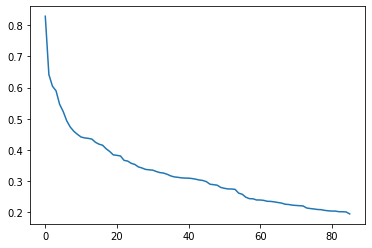

In [45]:
plt.plot(losses)

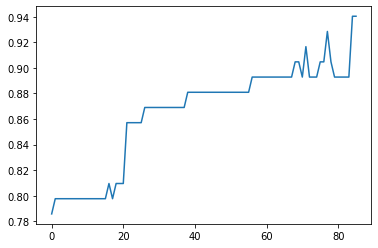

In [46]:
plt.plot(accuracies)

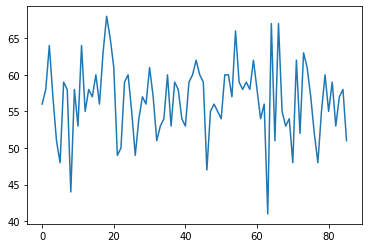

In [47]:
plt.plot(errors)